In [1]:
import requests
from bs4 import BeautifulSoup
import csv
import time
import pandas as pd
import lxml
import re
import numpy as np
from matplotlib import pyplot as plt

# 1. Introduction

# 2. Getting Top 20 List

The purpose of this section is to aggregate the list of players who have been on every year's HLTV Top 20. The entire process is not computationally laborious, so the resulting DataFrame was not saved locally.

The function **_getTop20(year, index)_** accepts a certain year as well as the dictionary of indices to each list's webpage on hltv.com. A couple of exceptions had to be made because it appeared that HLTV changed their HTML webpages between the years 2017 and 2018. This resulted in the player extraction for years 2018 and 2019 to be harder. The function returns an array that has the player names in order from #1 to #20.

The function **_aggregateTop20()_** serves as the main function that uses the helper function **_getTop20_**. I went to each year's introduction page and took down the index numbers, which were unique. Luckily, the rest of the url were the same across all four, making iteration easy. Since **_getTop20_** returns a 20x1 numpy array, the **_aggregateTop20_** makes a 20x4 numpy array. This numpy array was then converted and returned as a DataFrame.

In [2]:
def getTop20(year, index):
    url = 'https://www.hltv.org/news/' + str(index) + '/top-20-players-of-' + str(year) + '-introduction'
    src = requests.get(url).text
    soup = BeautifulSoup(src,'lxml')
    arr = np.array([])
    
    if year in [2016, 2017]:
        for i in soup.find_all('tr'):
            arr = np.concatenate((arr,[i.text.split()[2][1:-1]]))
    elif year in [2018, 2019]:
        top20 = soup.find_all('blockquote')[1].text.strip()
        top20list = re.compile("[0-9]+\.  ").split(top20)
        for player in top20list:
            if not len(player) <= 1:
                arr = np.concatenate((arr,[player.split('"')[1]]))
    else:
        print('Error')
    return arr


def aggregateTop20():  
    top20indices = {2016: 19558, 2017: 22348, 2018: 25735, 2019: 28749}

    top20 = np.array([])
    for year in top20indices:
        top20 = np.concatenate((top20,getTop20(year, top20indices[year]))) 
        time.sleep(1)
    df = pd.DataFrame(top20.reshape(4,20).swapaxes(0,1), columns=list(top20indices.keys()))
    df.index = np.arange(1,21)
    return df

top20DF = aggregateTop20()

# 3. Data Scraping: Feature Extraction

In this section, data scraping begins with finding individual statistics for all the players in a given year. These features will also be saved locally. Later, filtering will reduce the amount of players used in the machine learning model. The purpose of this section is to just save **all** players locally.

## 3-1. Unfiltered Players

Firstly, the player names from each year must be collected from HLTV's repo. Since HLTV did not publish advanced statistics until late 2015, only the years 2016, 2017, 2018, 2019 are used. 

Only LAN matches are counted, while no filter restriction is placed on the Player Filter. The **_oneYear(year)_** function is a helper function that returns a string that has the date range depending on the year supplied. Each year has its own HTML file, and the collection of all four HTML files are placed in the 'unfilteredplayers' folder.

In [3]:
def oneYear(year):
    return 'startDate=' + str(year) + '-01-01&endDate=' + str(year) + '-12-31'

# for year in np.arange(2016,2020):
#     url = 'https://www.hltv.org/stats/players?' + oneYear(year) + '&matchType=Lan'
#     temp = requests.get(url).text
#     with open('unfilteredplayers/players' + str(year) + '.html', 'w', encoding='utf-8') as f:
#         f.write(temp)
#     time.sleep(1)

These html files now must be read and turned into .csv files. The **_allplayersonLAN(year)_** function below takes in a year and reads that year's HTML page that has the list of players who have official statistics on LAN events only. A dictionary is returned that maps players' names to players' individual statistic page based on the year.

In [4]:
def allplayersonLAN(year):
    with open('unfilteredplayers/players' + str(year) + '.html','r',encoding='utf-8') as players_html:
        soup = BeautifulSoup(players_html,'lxml')
    temp = {}
    for player in soup.find_all('td',class_='playerCol'):
        temp[player.text] = 'https://hltv.org' + player.find('a')['href']
    return temp

The **_htmlToCsvUnfiltered(year)_** function is the main function that transforms the HTML files into CSV files. It uses **_allplayersonLAN_** as a helper function to produce a dictionary, which is then converted to a DataFrame and then exported as a .csv. These .csv files are then placed in 'unfilteredplayers' as well, accompanying the .html files.

In [5]:
def htmlToCsvUnfiltered(year): 
    playerlist = allplayersonLAN(year)
    tab = pd.DataFrame.from_dict(playerlist,orient='index',columns=['Webpage'])
    tab.to_csv('unfilteredplayers/players' + str(year) + '.csv')
    print(str(year) + "-Number of unfiltered players: " + str(len(playerlist)))
    return

# for year in np.arange(2016,2020):
#     htmlToCsvUnfiltered(year)

## 3-2. Did a player make HLTV?

In Section 2, **_aggregateTop20()_** produced a DataFrame of all the Top 20 lists for the four years. 

In [6]:
top20DF

,2016,2017,2018,2019
1,coldzera,coldzera,s1mple,ZywOo
2,FalleN,NiKo,device,s1mple
3,device,fer,NiKo,device
4,s1mple,rain,electronic,EliGE
5,Snax,device,dupreeh,Magisk
6,shox,FalleN,NAF,electronic
7,f0rest,kennyS,Magisk,NAF
8,olofmeister,s1mple,gla1ve,Brehze
9,ScreaM,GuardiaN,KRIMZ,Twistzz
10,flusha,dupreeh,coldzera,ropz


**_checkIfTop20(row,top20)_** is a function that is to be applied across a DataFrame of all the players. It takes in a DataFrame row as well as a Series that contains the Top 20 based on the provided year. An example is shown below with the players from 2019.

In [7]:
def checkIfTop20(row,top20):
    name = row.name
    if top20.str.contains(name,regex=False).sum() > 0:
        return True
    else:    
        return False

df = pd.read_csv('unfilteredplayers/players2019.csv',index_col=0)
df.insert(df.shape[1],'HLTV Top 20',df.apply(checkIfTop20,axis=1,args=(top20DF.loc[:,2019],)))
df

,Webpage,HLTV Top 20
Jamppi,https://hltv.org/stats/players/14087/Jamppi?st...,False
ZywOo,https://hltv.org/stats/players/11893/ZywOo?sta...,True
s1mple,https://hltv.org/stats/players/7998/s1mple?sta...,True
witz,https://hltv.org/stats/players/13995/witz?star...,False
Papichulo,https://hltv.org/stats/players/15440/Papichulo...,False
...,...,...
daps,https://hltv.org/stats/players/8521/daps?start...,False
tiziaN,https://hltv.org/stats/players/5796/tiziaN?sta...,False
HUNDEN,https://hltv.org/stats/players/7415/HUNDEN?sta...,False
advent,https://hltv.org/stats/players/8600/advent?sta...,False


## 3-3. Features

Feature extraction is based on the three tabs of a player: Overview, Individual, and Matches. A total of 12 statistics will be used as features:

- Rating Avg (0)
- Rating 5 (1)
- Rating 10 (2)
- Rating 20 (3)
- Rating 30 (4)
- Rating 50 (5)
- Maps 5 (6)
- Maps 10 (7)
- Maps 20 (8)
- Maps 30 (9)
- Maps 50 (10)
- ADR (11)
- KPR (12)
- DPR (13)
- APR (14)
- IMPACT (15)
- KAST (16)
- Grenade dmg (17)
- HS% (18)
- Rounds played (19)


- Rounds with kills (20)
- k-d diff (21)
- Opening kill ratio (22)
- Opening kill rating (23)
- team win percent after 1st kill (24)
- first kill in won rounds (25)
- Kill (26)
- Death(27)
- % of maps with 1+ rating (28)

**_getScaledRating(sp)_** is a helper function that scales player rating based on the player's rating against top 5, 10, 20, 30, and 50 opponents. **_getFromOverview(url,arr)_** is the main function that fills in a stats array with the statistics that can be taken from the player's overview page. 

- Rating (0)
- ADR (1)
- KPR (2)
- DPR (3)
- APR (4)
- IMPACT (5)
- KAST (6)
- Grenade dmg (7)

In [57]:
def getRating(sp,a):
    ratingsTab = sp.find('div',class_='featured-ratings-container')
    scales = {'vs top 5 opponents': 1,'vs top 10 opponents':2,'vs top 20 opponents':3,
                       'vs top 30 opponents':4,'vs top 50 opponents': 5}

    for rating in ratingsTab.find_all('div',class_='rating-breakdown'):
        ratingtype = rating.find('div',class_='rating-description').text
        mapcount = int(rating.find('div',class_='rating-maps').text[1:-1].split()[0])
        if mapcount == 0:
            continue 
        
        temp = float(rating.find('div',class_='rating-value').text)
        a[scales[ratingtype]] = temp  
        a[scales[ratingtype] + 5] = mapcount
    return a


def getFromOverview(url, arr):
    src = requests.get(url).text
    soup = BeautifulSoup(src,'lxml')
    statsIndex = {'Rating': 0, 'Rating5': 1,'Rating10': 2,'Rating20': 3, 'Rating30': 4, 'Rating50': 5,              
                  'ADR': 11, 'KPR': 12, 'DPR': 13, 'Assists / round': 14, 'Impact': 15, 'KAST': 16, 'Grenade dmg / Round': 17,
                  'Headshot %': 18, 'Rounds played': 19}
    
    # Ratin 2.0, ADR, KPR, DPR, KAST, IMPACT
    for i in soup.find_all('div',class_=re.compile('summaryStatBreakdown ')):
        statname = i.find('div',class_='summaryStatBreakdownSubHeader').text.split()[0]
        if statname in statsIndex:
            if statname == 'KAST':
                arr[statsIndex[statname]] = i.find('div',class_='summaryStatBreakdownDataValue').text[:-1]
            else:
                arr[statsIndex[statname]] = i.find('div',class_='summaryStatBreakdownDataValue').text
    
    # APR, Grenade Dmg/ Round
    for i in soup.find_all('div',class_='stats-row'):
        if i.text.find('Grenade dmg / Round') > -1:
            arr[statsIndex['Grenade dmg / Round']] = i.find_all('span')[1].text
        elif i.text.find('Assists / round') > -1:
            arr[statsIndex['Assists / round']] = i.find_all('span')[1].text
        elif i.text.find('Headshot %') > -1:
            arr[statsIndex['Headshot %']] = i.find_all('span')[1].text[:-1]
        elif i.text.find('Rounds played') > -1:
            arr[statsIndex['Rounds played']] = i.find_all('span')[1].text
                
        
    # Rating Scale
    arr = getRating(soup, arr)
    return arr


**_getFromIndividual(url,arr)_** is the main function that fills in a stats array with the statistics that can be taken from the player's Individual page. 

- k-d diff (8)
- Opening kill ratio (9)
- team win percent after 1st kill (10)

In [58]:
def getFromIndividual(url, arr):
    src = requests.get(url).text
    soup = BeautifulSoup(src,'lxml')
    statsIndex = {'Rounds with kills': 20, 'Kill - Death difference': 21, 'Opening kill ratio': 22, 'Opening kill rating': 23,
                  'Team win percent after first kill': 24, 'First kill in won rounds': 25, 'Kills': 26, 'Deaths': 27}
    for i in soup.find_all('div',class_='stats-row'):
        statname = i.span.text
        if statname in statsIndex:
            if statname == 'Kill - Death difference':
                arr[statsIndex[statname]] = i.span.next_sibling.next_sibling.text
            elif statname == 'Team win percent after first kill':
                arr[statsIndex[statname]] = i.span.next_sibling.text[:-1]
            elif statname == 'First kill in won rounds':
                arr[statsIndex[statname]] = i.span.next_sibling.text[:-1]
            else:
                arr[statsIndex[statname]] = i.span.next_sibling.text
                
    return arr

**_getFromMatches(url,arr)_** is the main function that fills in a stats array with the statistics that can be taken from the player's Matches page. 

- % of maps with 1+ rating (11)

In [59]:
def getFromMatches(url, arr):
    src = requests.get(url).text
    soup = BeautifulSoup(src,'lxml')
    statsIndex = {'Maps with 1+ rating': 28}
    for i in soup.find_all('div',class_='col'):
        statname = i.find('div',class_='description').text
        if statname is None:
            continue
        elif statname in statsIndex:
            arr[statsIndex[statname]] = i.find('div',class_='value').text[:-1]
            break
    return arr

**_getFeatures(row)_** is applied across an entire DataFrame and uses the three functions defined above. It takes in a row and returns a numpy array that contains the statistics. 

In [60]:
def getFeatures(row):
    statsarr = np.zeros((29,))
    
    print("Working on:" + str(row.name))
    
    overvUrl = row['Webpage']
    statsarr = getFromOverview(overvUrl,statsarr)
    time.sleep(7.5)
    indivUrl = overvUrl[:31] + 'individual/' + overvUrl[31:]
    statsarr = getFromIndividual(indivUrl,statsarr)
    time.sleep(7.5)
    matchUrl = overvUrl[:31] + 'matches/' + overvUrl[31:]
    statsarr = getFromMatches(matchUrl,statsarr)
    time.sleep(7.5)
    return statsarr

Since applying **_getFeatures_** returns a Series of 12x1 numpy arrays, this nested structure needs to be flattened into a non-nested two-dimensional array. **_flattenFeatures(s,df)** extracts the nested structure made from the applied function and combines it with the existing DataFrame that came from the end of section 3-1. The Series is first converted into a numpy array, then numpy's **stack** function will flatten it. It is then concatenated with the original DataFrame that just had player names and hltv URLs.

In [61]:
def flattenFeatures(s,df):
    flat = np.stack(s.to_numpy())
   
    featureNames = np.array(['Rating','RatingV5','RatingV10','RatingV20','RatingV30','RatingV50',
                             'MapsV5','MapsV10','MapsV20','MapsV30','MapsV50',
                             'ADR','KPR','DPR','APR', 'Impact','KAST','NadeDPR','HS%','Rounds played',
                             'Rounds with kills', 'K-D Diff', 'Opening kill ratio', 'Opening kill rating',
                             'Team win % after 1st kill', 'First kill in won rounds','Kills','Deaths',
                             '% of maps with 1+ rating'])
    features = pd.DataFrame(data=flat, columns=featureNames)
    features.index = df.index
    
    final = pd.concat([df,features],axis=1)
    return final

Since applying **_extractFinalFeature_** is the main function for feature extraction. It takes in a year as well as the top20DF created in section 2. It reads in the DataFrame saved in section 3-1 and then adds a column checking whether or not a player made it in that year's HLTV top 20. It will then call **_getFeatures_** to produce the Series of numpy arrays that contains all the stats. That series is inserted along with the DataFrame into **_flattenFeatures_** to produce a combined DataFrame with all the features necessary for analysis. 

In [62]:
def extractFinalFeatures(year):
    top20DF = aggregateTop20()
    df = pd.read_csv('unfilteredplayers/players' + str(year) + '.csv',index_col=0).iloc[:5,:]
    df.insert(df.shape[1],'HLTV Top 20',df.apply(checkIfTop20,axis=1,args=(top20DF.loc[:,year],)))
    
    statsonly = df.apply(getFeatures,axis=1)
    
    finalTab = flattenFeatures(statsonly,df)
    
    finalTab.to_csv('features/meme'+str(year)+'.csv') 
    
    return

extractFinalFeatures(2016)

Working on:XANTARES
Working on:XANTARES
Working on:ZELIN
Working on:coldzera
Working on:oskar
Working on:device


# 4. Data Scraping: Filtering Players

## Defining the Filter Function

The **_againstTop50(row)_** function checks if each player in the dictionary above has at least played 20 maps against rank top 50 opponents. It takes in a DataFrame row, and this function will be applied across the entire DataFrame using panda's **apply()** function. The return is boolean: true if player has played at least 20 maps against top 50 opponents, and false if player has not. 

This portion of the filtering process might be subject to change. 20 maps against top 50 opponents appears to be a very low bar to clear, might adjust later.

In [15]:
def againstTop50(row):
    name = row.name
    url = row.Webpage
    src = requests.get(url).text
    soup = BeautifulSoup(src,'lxml')
    for i in soup.find_all('div',class_='col-custom'):
        if i.text.find('top 50 opponents') > -1:
            mapsplayed = i.find('div',class_='rating-maps').text.split()[0].split('(')[1]
            if int(mapsplayed) >= 20:
                return True
    time.sleep(7.5)
    return False

This function combines the two above to filter out players that may have not participated in enough important events. A dictionary is formed using allplayersonLAN() and then converted into a DataFrame. The againstTop50 function is applied across every row of the DataFrame to produce a Series that says if each player has or has not played 20 maps against top 50 opponenets.

- 2016-Number of unfiltered players: 190
- 2016-Number of filtered players: 171
- 2017-Number of unfiltered players: 284
- 2017-Number of filtered players: 181
- 2018-Number of unfiltered players: 252
- 2018-Number of filtered players: 223
- 2019-Number of unfiltered players: 234
- 2019-Number of filtered players: 186

In [16]:
def filterPlayers(year): 
    tab = pd.read_csv('unfilteredplayers/players' + str(year) + '.csv',index_col=0)
    tab.insert(tab.shape[1],'AgainstTop50',tab.apply(againstTop50,axis=1))
    tab[tab.AgainstTop50].to_csv('filteredplayers/f_players' + str(year) + '.csv')
    print(str(year) + "-Number of unfiltered players: " + str(tab.shape[0]))
    print(str(year) + "-Number of filtered players: " + str(tab[tab.AgainstTop50].shape[0]))
    return

# for year in np.arange(2016,2020):
#     filterPlayers(year)

## Filtering the Table

In [17]:
def makeFilteredTable(year):
    t1 = pd.read_csv('features/features' + str(year) + '.csv',index_col=0).drop(labels='Webpage',axis=1)
    t2 = pd.read_csv('filteredplayers/f_players' + str(year) + '.csv',index_col=0).drop(labels='AgainstTop50',axis=1)
    return t1.merge(t2,left_index=True,right_index=True)

tab2016 = makeFilteredTable(2016)
tab2016

,HLTV Top 20,Rating,RatingV5,RatingV10,RatingV20,RatingV30,RatingV50,ADR,KPR,DPR,...,Rounds with kills,K-D Diff,Opening kill ratio,Opening kill rating,Team win % after 1st kill,First kill in won rounds,Kills,Deaths,% of maps with 1+ rating,Webpage
XANTARES,False,1.46,0.00,0.00,1.46,1.36,1.38,104.3,0.95,0.67,...,863,415,1.60,1.37,78.7,23.9,1425,1010,95.1,https://hltv.org/stats/players/7938/XANTARES?s...
coldzera,True,1.20,1.13,1.18,1.19,1.20,1.20,83.0,0.81,0.61,...,2123,807,1.54,1.03,78.1,13.0,3247,2440,79.5,https://hltv.org/stats/players/9216/coldzera?s...
oskar,False,1.20,1.28,1.09,1.23,1.22,1.25,82.7,0.81,0.63,...,1075,369,1.64,1.28,74.1,22.0,1672,1303,75.3,https://hltv.org/stats/players/798/oskar?start...
device,True,1.22,1.12,1.15,1.19,1.21,1.21,82.8,0.79,0.62,...,1796,608,1.39,1.19,77.4,19.8,2809,2201,75.9,https://hltv.org/stats/players/7592/device?sta...
mou,False,1.19,0.90,1.04,1.09,1.12,1.16,80.6,0.80,0.61,...,1142,405,1.42,1.19,80.5,19.8,1739,1334,70.2,https://hltv.org/stats/players/964/mou?startDa...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
B1ad3,False,0.85,0.81,0.87,0.87,0.89,0.89,69.3,0.60,0.72,...,938,-273,0.89,0.94,71.0,13.4,1304,1577,36.9,https://hltv.org/stats/players/472/B1ad3?start...
MSL,False,0.94,0.89,0.89,0.90,0.92,0.92,69.8,0.60,0.73,...,1653,-496,0.74,0.97,74.9,15.6,2326,2822,45.6,https://hltv.org/stats/players/7156/MSL?startD...
nkl,False,0.84,0.79,0.79,0.82,0.82,0.85,65.7,0.58,0.70,...,748,-211,0.94,0.93,74.5,11.8,1016,1227,34.3,https://hltv.org/stats/players/5327/nkl?startD...
freakazoid,False,0.89,0.75,0.71,0.86,0.88,0.89,68.2,0.59,0.74,...,563,-208,0.70,0.88,64.3,12.0,801,1009,35.8,https://hltv.org/stats/players/7808/freakazoid...


# 5. Analysis: Using just adjusted rating

Baseball metrics have WAR and basketball metrics have PER. Likewise, HLTV uses an index called rating that seemingly captures the individual performance of a player in a single match. However, players would intuitively perform better against weaker teams than stronger ones, so it would make sense to have high ratings against weak teams. 

The function below scales ratings, rewarding players with high volume, high-performing games against strong opponents.  

In [31]:
# def getScaledRating(row):
#     scales = {'RatingV5': 0.4, 'RatingV10': 0.3, 'RatingV20': 0.2, 
#               'RatingV30': 0.075, 'RatingV50': 0.025}
#     print(row.name)
#     scaledrating = 0

#     for rat in scales:
#         temp = row[rat] * scales[rat] 
#         #print(rat + ' ' + str(row[rat]))
#         if rat == 'RatingV5' and mapcount < 10:
#             temp *= 0.75
#         elif rat == 'RatingV10' and mapcount < 20:
#             temp *= 0.75
#         elif ratingtype== 'RatingV20' and mapcount < 40:
#             temp *= 0.75   
#         scaledrating += temp
#     return scaledrating

# tab2016.apply(getScaledRating,axis=1)
# #tab2016.loc[:,['RatingV5','RatingV10','RatingV20','RatingV30','RatingV50']]

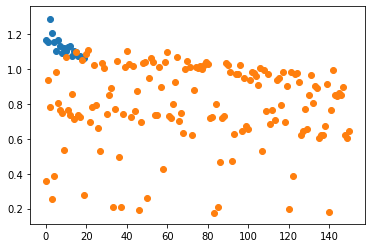

In [57]:

x_hltv = np.arange(tab2016[tab2016['HLTV Top 20']].shape[0])
y_hltv = tab2016[tab2016['HLTV Top 20']].loc[:,'Adj. Rating']

x_nohltv = np.arange(tab2016[~tab2016['HLTV Top 20']].shape[0])
y_nohltv = tab2016[~tab2016['HLTV Top 20']].loc[:,'Adj. Rating']

plt.scatter(x_hltv,y_hltv)
plt.scatter(x_nohltv,y_nohltv)

In [ ]:
# def getRating(sp):
#     ratingsTab = sp.find('div',class_='featured-ratings-container')
#     scales = {'vs top 5 opponents': 0.4, 'vs top 10 opponents': 0.3, 'vs top 20 opponents': 0.2, 
#               'vs top 30 opponents': 0.075, 'vs top 50 opponents': 0.025}
#     scaledrating = 0
#     for rating in ratingsTab.find_all('div',class_='rating-breakdown'):
#         val = 0
#         ratingtype = rating.find('div',class_='rating-description').text
#         mapcount = int(rating.find('div',class_='rating-maps').text[1:-1].split()[0])
#         if mapcount == 0:
#             continue 
        
#         temp = float(rating.find('div',class_='rating-value').text)
#         val = temp * scales[ratingtype]
        
#         if ratingtype == 'vs top 5 opponents' and mapcount < 10:
#             val *= 0.75
#         elif ratingtype== 'vs top 10 opponents' and mapcount < 20:
#             val *= 0.75
#         elif ratingtype== 'vs top 20 opponents' and mapcount < 40:
#             val *= 0.75       
#         scaledrating += val

#     return scaledrating   
    
